# Transfer Learning

**Transfer Learning** is a deep learning technique where a model trained on one task is reused (partially or fully) for a different, but related, task.

Instead of training a neural network from scratch, we "transfer" the knowledge from a **pre-trained model**, usually trained on a large dataset like **ImageNet**, to a new problem with limited data.


## Why Is Transfer Learning Useful?

**Leverages Pretrained Knowledge**  
Pre-trained models have already learned useful feature detectors (e.g., edges, textures, shapes), which can be reused for your new task.

**Works Well with Small Datasets**  
You don’t need millions of images. Fine-tuning a pretrained model often gives great performance on smaller, domain-specific datasets.

**Faster Training & Lower Compute Cost**  
Training starts with weights that are already close to optimal, which reduces training time and computational cost.

**Common in Practice**  
Transfer learning is widely used in fields like:
- Medical image analysis
- Remote sensing
- Astrophysics (e.g., galaxy morphology)
- High-energy physics (e.g., jet image classification)

Next, we’ll load a pretrained model and fine-tune it on a new task using PyTorch.


---
---

## ResNet

**ResNet**, short for **Residual Network**, is a family of deep neural networks introduced by Microsoft Research in 2015.

> Reference: He et al., *"Deep Residual Learning for Image Recognition"*, [arXiv:1512.03385](https://arxiv.org/abs/1512.03385)

## The Problem with Very Deep Networks

As we add more layers to a neural network, it becomes harder to train:
- Gradients can **vanish** or **explode**
- Performance can **saturate or degrade**, even with more parameters


## ResNet’s Solution: Residual Connections

ResNet introduces **skip connections** (also called **residual connections**) that let the input of a layer **"skip over"** one or more layers:

$$
\text{Output} = \mathcal{F}(x) + x
$$

Where:
- $x$ is the input
- $\mathcal{F}(x)$ is a small transformation (e.g., convolution + ReLU)

This helps:
- Preserve gradient flow during backpropagation
- Make very **deep networks (like 50 or 101 layers)** trainable


## ResNet Architecture Highlights

- **ResNet18**: 18 layers — good balance of performance and speed
- **ResNet50**: 50 layers — deeper, more powerful
- **Key innovation**: Uses **blocks** with residual/shortcut connections

## Why Use ResNet for Transfer Learning?

- Pretrained ResNet models (like `resnet18`) are available in PyTorch
- Already trained on ImageNet (1M+ images)
- Can be **fine-tuned** for new tasks like digit classification

In our case, we’ll adapt **ResNet18** to classify MNIST digits (0–9).
> Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.  
> **"Deep Residual Learning for Image Recognition"**  
> *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016*  
> 📄 [arXiv:1512.03385](https://arxiv.org/abs/1512.03385)


In [3]:
import torchvision.models as models

# Load ResNet18 pretrained on ImageNet
resnet18 = models.resnet18(weights=True)

# Print the model architecture
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/waleed/micromamba/envs/pytorch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Now load the MNIST Dataset

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms: Resize to 224x224, convert grayscale to 3 channels, and convert to tensor
mnist_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize to match ResNet18 input
    transforms.Grayscale(num_output_channels=3),# Convert 1-channel to 3-channel
    transforms.ToTensor(),                      # Convert to PyTorch tensor
])

# Load training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=mnist_transform
)

# Load test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=mnist_transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Show dataset info
print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))


Training set size: 60000
Test set size: 10000


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# -----------------------------------------------------
# 1. Load pre-trained ResNet18 and modify for MNIST
# -----------------------------------------------------
resnet18 = models.resnet18(weights=True)            # Load pretrained ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)   # Replace final layer (1000 → 10 classes)

# -----------------------------------------------------
# 2. Choose device
# -----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet18.to(device)                            # Move model to GPU/CPU

# -----------------------------------------------------
# 3. Define loss function and optimizer
# -----------------------------------------------------
criterion = nn.CrossEntropyLoss()                      # Multi-class classification loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD optimizer with momentum

# -----------------------------------------------------
# 3. Fine-tuning loop
# -----------------------------------------------------
epochs = 5                      # Number of training epochs
loss_vals = []                  # Store loss values for plotting later

for epoch in range(epochs):
    model.train()               # Set model to training mode
    total_loss = 0.0            # Accumulate loss for this epoch

    for images, labels in train_loader:
        # Move batch to device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass: compute predicted outputs
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass: zero gradients, compute gradients, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Add batch loss to total

    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    loss_vals.append(avg_loss)

    # Print progress
    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")


/home/waleed/micromamba/envs/pytorch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Epoch  1 | Loss: 0.0569
Epoch  2 | Loss: 0.0153
Epoch  3 | Loss: 0.0087
Epoch  4 | Loss: 0.0053
Epoch  5 | Loss: 0.0032



✅ Test Accuracy: 99.63%


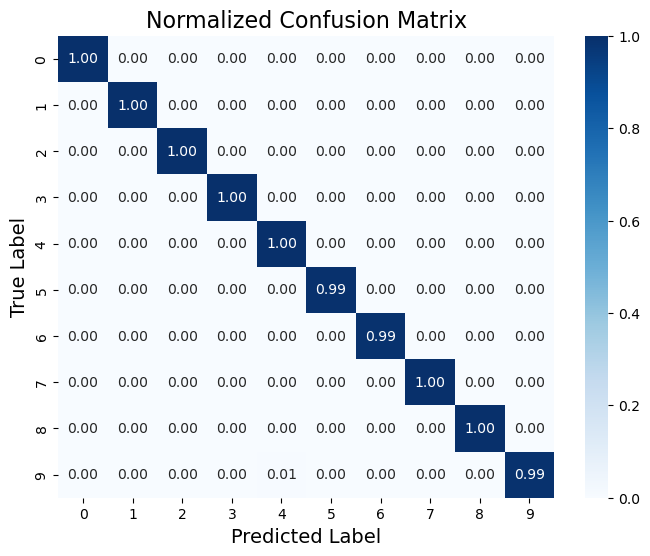

In [7]:
# Import statments
from torchmetrics.classification import Accuracy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------
# Define accuracy metric using torchmetrics library `pip install torchmetrics`
# -----------------------------------------------------
metric = Accuracy(task="multiclass", num_classes=10).to(device)

# -----------------------------------------------------
# Evaluate model and collect predictions/labels
# -----------------------------------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        # Update accuracy metric
        metric.update(preds, labels)

        # Store for confusion matrix
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# -----------------------------------------------------
# Compute final accuracy
# -----------------------------------------------------
accuracy = metric.compute().item()
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# -----------------------------------------------------
# Confusion Matrix (normalized)
# -----------------------------------------------------
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

cm = confusion_matrix(y_true, y_pred, normalize='true')

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Normalized Confusion Matrix", fontsize=16)
plt.show()
